In [1]:
import pathlib

import flax
import jax
import jax.numpy as jnp
import numpy as np
import orbax.checkpoint as orbax
from flax import nnx
from jax.sharding import PartitionSpec as P
from rte_dataset.builders import pipeline

from deeprte.configs import default
from deeprte.model import features
from deeprte.model.mapping import inference_subbatch
from deeprte.model.predicter import RtePredictor
from deeprte.model.tf import rte_features
from deeprte.train_lib import utils
from deeprte.train_lib.utils import get_abstract_state

In [2]:
path = "/workspaces/deeprte/ckpts/g0.1-gaussian-rte0202"
config = default.get_config(path + "/config.yaml")

In [3]:
devices_array = utils.create_device_mesh(config, devices=jax.local_devices())
mesh = jax.sharding.Mesh(devices_array, config.mesh_axes)

replicated_sharding = jax.sharding.NamedSharding(mesh, P(None))
data_sharding = jax.sharding.NamedSharding(mesh, P(None, *config.data_sharding))

feature_sharding = {
    k: data_sharding if k in rte_features.PHASE_COORDS_FEATURES else replicated_sharding
    for k in rte_features.FEATURES
}

rngs = jax.random.key(0)

In [4]:
model = RtePredictor


def constructor(config, rngs):
    return RtePredictor(config, rngs=nnx.Rngs(params=rngs))


In [5]:
abstract_state, state_sharding = get_abstract_state(
    constructor=lambda config, rngs: RtePredictor(config, rngs=nnx.Rngs(params=rngs)),
    tx=None,
    config=config,
    rng=rngs,
    mesh=mesh,
    is_training=False,
)

In [6]:
config.load_parameters_path = (
    "/workspaces/deeprte/ckpts/g0.1-gaussian-source0121/infer/params",
    "/workspaces/deeprte/ckpts/g0.1-gaussian-rte0202/infer/params",
)

In [22]:
checkpointer = orbax.PyTreeCheckpointer()
_params = {}
for path in config.load_parameters_path:
    _res_params = checkpointer.restore(path)
    if "green_function" in _res_params["params"]:
        _params = _params | _res_params["params"]
    else:
        autoencoder = dict(autoencoder=_res_params["params"])
        _params = _params | autoencoder

/usr/local/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1591: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [23]:
flax.traverse_util.flatten_dict(_params).keys()

dict_keys([('autoencoder', 'mlp', 'layers', 'layers', '0', 'bias', 'value'), ('autoencoder', 'mlp', 'layers', 'layers', '0', 'kernel', 'value'), ('autoencoder', 'mlp', 'layers', 'layers', '2', 'bias', 'value'), ('autoencoder', 'mlp', 'layers', 'layers', '2', 'kernel', 'value'), ('autoencoder', 'mlp', 'layers', 'layers', '4', 'bias', 'value'), ('autoencoder', 'mlp', 'layers', 'layers', '4', 'kernel', 'value'), ('autoencoder', 'mlp', 'layers', 'layers', '6', 'bias', 'value'), ('autoencoder', 'mlp', 'layers', 'layers', '6', 'kernel', 'value'), ('green_function', 'attenuation', 'attention', 'key', 'bias', 'value'), ('green_function', 'attenuation', 'attention', 'key', 'kernel', 'value'), ('green_function', 'attenuation', 'attention', 'out', 'bias', 'value'), ('green_function', 'attenuation', 'attention', 'out', 'kernel', 'value'), ('green_function', 'attenuation', 'attention', 'query', 'bias', 'value'), ('green_function', 'attenuation', 'attention', 'query', 'kernel', 'value'), ('green_fun

In [24]:
graph_def, state = utils.module_from_variables_dict(
    lambda: nnx.eval_shape(lambda: RtePredictor(config, rngs=nnx.Rngs(params=rngs))),
    _params,
    lambda path: path[:-1] if path[-1] == "value" else path,
)
params = utils.init_infer_state(None, state).params


In [25]:
def predict_fn(params, features, graphdef):
    return nnx.merge(graphdef, params)(features)


In [26]:
jit_predict_fn = jax.jit(
    predict_fn,
    in_shardings=(state_sharding.params, feature_sharding),
    out_shardings=data_sharding,
    static_argnums=2,
)

In [28]:
# data_path = pathlib.Path(
#     "/workspaces/deeprte/data/raw_data/train/g0.1-q0.003/g0.1-q0.003.npz"
# )
# data_path = pathlib.Path(
#     "/workspaces/deeprte/data/raw_data/test/source-g0.1-qconstant/g0.1-qconstant.npz"
# )
data_path = pathlib.Path(
    "/workspaces/deeprte/data/raw_data/train/g0.1-gaussian-alpha5/g0.1-gaussian-alpha5.npz"
)
data_pipeline = pipeline.DataPipeline(data_path.parent, [data_path.name])
raw_feature_dict = data_pipeline.process()
del data_pipeline


In [29]:
i = 480

feature_dict = {
    "functions": jax.tree.map(lambda x: x[i : i + 1], raw_feature_dict["functions"]),
    "grid": raw_feature_dict["grid"],
    "shape": raw_feature_dict["shape"],
}


In [30]:
processed_feature_dict = features.np_data_to_features(feature_dict)
phase_feat, other_feat = features.split_feature(
    processed_feature_dict, filter=lambda x: x in rte_features.PHASE_COORDS_FEATURES
)


In [31]:
other_feat.keys()


dict_keys(['boundary', 'self_scattering_kernel', 'sigma', 'source', 'position_coords', 'velocity_coords', 'boundary_coords', 'boundary_weights', 'velocity_weights', 'source_coords', 'source_weights'])

In [32]:
_out = inference_subbatch(
    module=lambda x: jit_predict_fn(params, x, graph_def),
    subbatch_size=128,
    batched_args=phase_feat,
    nonbatched_args=other_feat,
    low_memory=True,
    input_subbatch_dim=1,
)


In [33]:
%timeit inference_subbatch(module=lambda x: jit_predict_fn(params, x, graph_def),subbatch_size=128,batched_args=phase_feat,nonbatched_args=other_feat,low_memory=True,input_subbatch_dim=1,)

1.24 s ± 23.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
_out.shape

(1, 38400)

In [35]:
import pathlib

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from absl import logging
from matplotlib.colors import ListedColormap
from rte_dataset.builders import pipeline


def plot_phi(r, phi_pre, phi_label):
    fig, _axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
    fig.subplots_adjust(hspace=0.3)
    axs = _axs.flatten()

    viridis = matplotlib.colormaps["viridis"](np.linspace(0, 1.2, 128))
    cs_1 = axs[0].contourf(
        r[..., 0], r[..., 1], phi_label, cmap=ListedColormap(viridis)
    )
    axs[0].set_title(r"Exact $f(x,v)$", fontsize=20)
    axs[0].tick_params(axis="both", labelsize=15)
    cbar = fig.colorbar(cs_1)
    cbar.ax.tick_params(labelsize=16)

    cs_2 = axs[1].contourf(r[..., 0], r[..., 1], phi_pre, cmap=ListedColormap(viridis))
    axs[1].set_title(r"Predict $f(x,v)$", fontsize=20)
    axs[1].tick_params(axis="both", labelsize=15)
    cbar = fig.colorbar(cs_2)
    cbar.ax.tick_params(labelsize=16)

    cs_3 = axs[2].contourf(
        r[..., 0],
        r[..., 1],
        abs(phi_pre - phi_label),
        cmap=ListedColormap(viridis),
    )
    axs[2].set_title(r"Absolute error", fontsize=20)
    axs[2].tick_params(axis="both", labelsize=15)
    cbar = fig.colorbar(cs_3)
    cbar.ax.tick_params(labelsize=16)

    plt.tight_layout()


In [41]:
out = (_out) * 0.35983075926348573

In [42]:
def rmse(pred, target):
    return jnp.sqrt(jnp.mean((pred - target) ** 2) / jnp.mean(target**2))


rmse(out, feature_dict["functions"]["psi_label"].reshape(1, -1))


Array(0.03432072, dtype=float32)

In [43]:
raw_feature_dict["grid"].keys()

dict_keys(['position_coords', 'velocity_coords', 'phase_coords', 'boundary_coords', 'boundary_weights', 'velocity_weights', 'source_coords', 'source_weights'])

In [44]:
rmse(
    out.reshape(40, 40, 24) @ feature_dict["grid"]["velocity_weights"],
    feature_dict["functions"]["psi_label"].reshape(40, 40, 24)
    @ feature_dict["grid"]["velocity_weights"],
)

Array(0.02192656, dtype=float32)

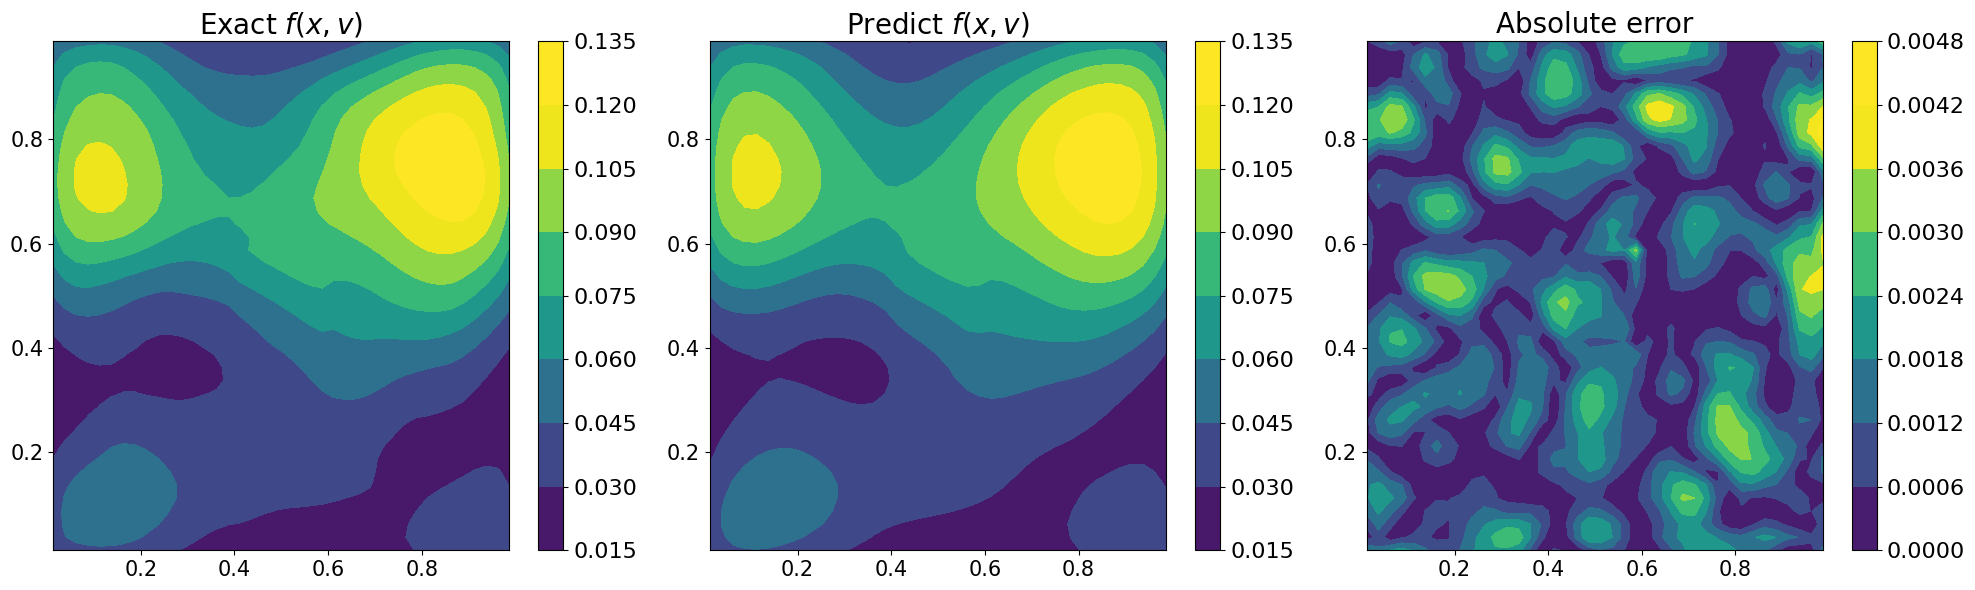

In [45]:
# feature_dict["grid"]["position_coords"].shape
plot_phi(
    feature_dict["grid"]["position_coords"],
    out.reshape(40, 40, 24) @ feature_dict["grid"]["velocity_weights"],
    feature_dict["functions"]["psi_label"].reshape(40, 40, 24)
    @ feature_dict["grid"]["velocity_weights"],
)